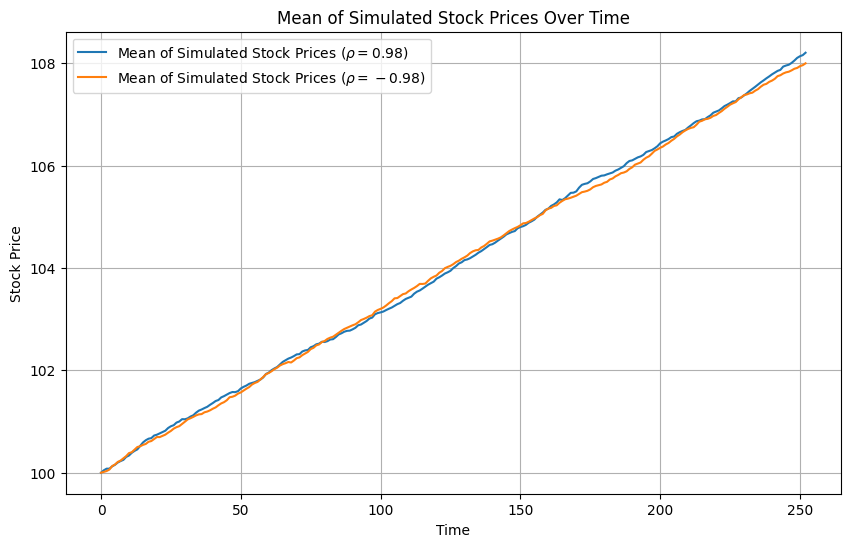

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from py_vollib_vectorized import vectorized_implied_volatility as implied_vol

# Heston model simulation function
def heston_model_sim(S0, v0, rho, kappa, theta, sigma, T, N, M):
    """
    Inputs:
     - S0, v0: initial parameters for asset and variance
     - rho   : correlation between asset returns and variance
     - kappa : rate of mean reversion in variance process
     - theta : long-term mean of variance process
     - sigma : vol of vol / volatility of variance process
     - T     : time of simulation
     - N     : number of time steps
     - M     : number of scenarios / simulations

    Outputs:
    - asset prices over time (numpy array)
    - variance over time (numpy array)
    """
    # initialise other parameters
    dt = T / N
    mu = np.array([0, 0])
    cov = np.array([[1, rho], [rho, 1]])

    # arrays for storing prices and variances
    S = np.full(shape=(N + 1, M), fill_value=S0)
    v = np.full(shape=(N + 1, M), fill_value=v0)

    # sampling correlated brownian motions under risk-neutral measure
    Z = np.random.multivariate_normal(mu, cov, (N, M))

    for i in range(1, N + 1):
        S[i] = S[i - 1] * np.exp((r - 0.5 * v[i - 1]) * dt + np.sqrt(v[i - 1] * dt) * Z[i - 1, :, 0])
        v[i] = np.maximum(v[i - 1] + kappa * (theta - v[i - 1]) * dt + sigma * np.sqrt(v[i - 1] * dt) * Z[i - 1, :, 1], 0)

    return S, v

# Parameters
# simulation dependent
S0 = 100.0             # asset price, must be initialized as a float
T = 1.0                # time in years
r = 0.08               # risk-free rate
N = 252                # number of time steps in simulation
M = 10000              # number of simulations

# Heston dependent parameters
kappa = 3              # rate of mean reversion of variance under risk-neutral dynamics
theta = 0.20**2        # long-term mean of variance under risk-neutral dynamics
v0 = 0.25**2           # initial variance under risk-neutral dynamics
rho = 0.7              # correlation between returns and variances under risk-neutral dynamics
sigma = 0.6            # volatility of volatility

rho_p = 0.98
rho_n = -0.98

S_p, v_p = heston_model_sim(S0, v0, rho_p, kappa, theta, sigma, T, N, M)
S_n, v_n = heston_model_sim(S0, v0, rho_n, kappa, theta, sigma, T, N, M)

# Calculate the mean of all simulated stock prices at each time step
mean_S_p = np.mean(S_p, axis=1)
mean_S_n = np.mean(S_n, axis=1)

# Plot the mean of the simulated stock prices
plt.figure(figsize=(10, 6))
plt.plot(mean_S_p, label=f'Mean of Simulated Stock Prices ($ρ={rho_p}$)')
plt.plot(mean_S_n, label=f'Mean of Simulated Stock Prices ($ρ={rho_n}$)')
plt.title('Mean of Simulated Stock Prices Over Time')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


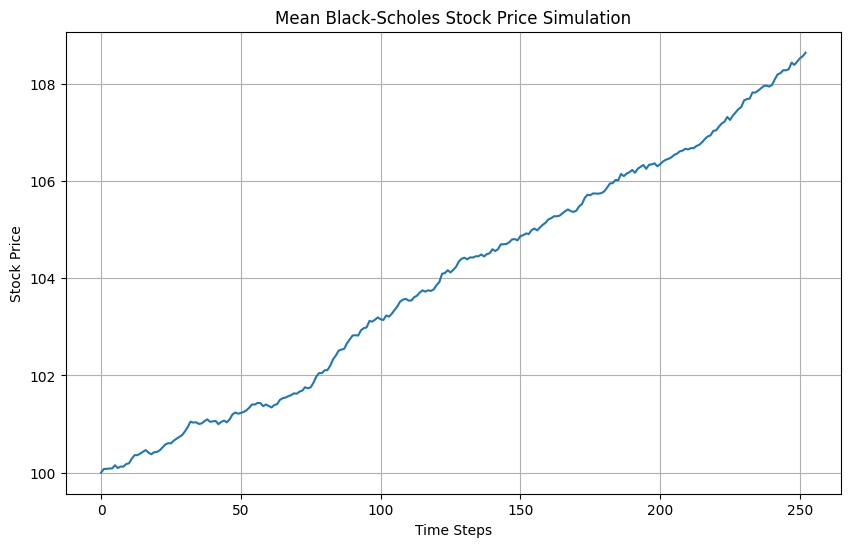

In [16]:
import numpy.random as npr
from numpy.random import default_rng

def black_scholes_sim(S0, r, sigma, T, N, M):
    dt = T / N
    paths = np.zeros((M, N + 1))
    paths[:, 0] = S0
    
    for i in range(1, N + 1):
        rand_nums = default_rng().standard_normal(M)
        paths[:, i] = paths[:, i-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * rand_nums)
    
    return paths

# Parameters
S0 = 100.0             # initial stock price
r = 0.08               # risk-free rate
sigma_p = 0.25         # volatility for positive correlation
sigma_n = 0.25         # volatility for negative correlation
T = 1.0                # time in years
N = 252                # number of time steps
M = 10000              # number of simulations

bs_sim = black_scholes_sim(S0, r, sigma, T, N, M)

# Calculate the mean of the simulated stock price paths
mean_path = np.mean(bs_sim, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(mean_path)
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.title('Mean Black-Scholes Stock Price Simulation')
plt.grid(True)
plt.show()

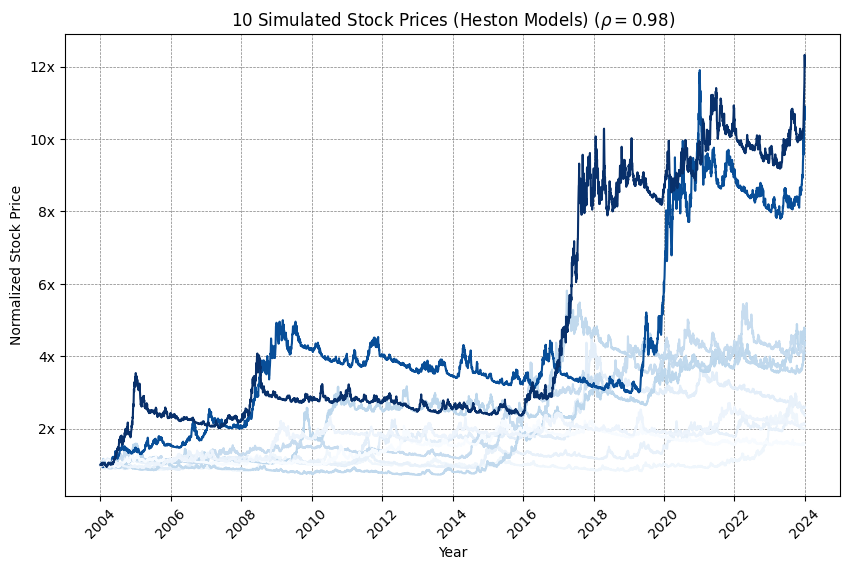

In [17]:
from matplotlib.ticker import FuncFormatter
from numpy.random import default_rng
import matplotlib.cm as cm

# Parameters
# simulation dependent
S0 = 100.0             # asset price, must be initialized as a float
T = 1.0 * 20           # time in years
r = 0.08               # risk-free rate
N = 252 * 20           # number of time steps in simulation
M = 10                 # number of simulations

# Heston dependent parameters
kappa = 3              # rate of mean reversion of variance under risk-neutral dynamics
theta = 0.20**2        # long-term mean of variance under risk-neutral dynamics
v0 = 0.25**2           # initial variance under risk-neutral dynamics
rho = 0.7              # correlation between returns and variances under risk-neutral dynamics
sigma = 0.6            # volatility of volatility

rho_p = 0.98

S_p, v_p = heston_model_sim(S0, v0, rho_p, kappa, theta, sigma, T, N, M)

# Normalize S_p
S_p_norm = S_p / S_p[0]

# Calculate the final values to determine color and alpha mapping
final_values = S_p_norm[-1]
norm = plt.Normalize(final_values.min(), final_values.max())
colors = cm.Blues(norm(final_values))  # Use a colormap with cool colors

# Plot the simulated stock prices with dark background and neon colors
fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')

# Set the figure and axes background color
ax.set_facecolor('white')

# Plot each stock path with varying transparency based on final value
for i in range(M):
    ax.plot(S_p_norm[:, i], color=colors[i], alpha=1)

# Customize plot elements
ax.set_title(f'{M} Simulated Stock Prices (Heston Models) ($ρ={rho_p}$)', color='black')
ax.set_xlabel('Year', color='black')
ax.set_ylabel('Normalized Stock Price', color='black')

# Set the y-axis formatter
formatter = FuncFormatter(lambda y, _: '{:,.0f}x'.format(y))
ax.yaxis.set_major_formatter(formatter)
ax.yaxis.set_tick_params(labelcolor='black')

# Generate the years for the x-axis
years = np.linspace(2004, 2004 + T, N + 1)
ax.set_xticks(np.arange(0, N + 1, N // 10))  # Set x-ticks every 2 years
ax.set_xticklabels(years[::N//10].astype(int), color='black')  # Set x-tick labels as years
plt.xticks(rotation=45)
ax.xaxis.set_tick_params(labelcolor='black')

# Customize gridlines
ax.grid(color='gray', linestyle='--', linewidth=0.5)

plt.show()

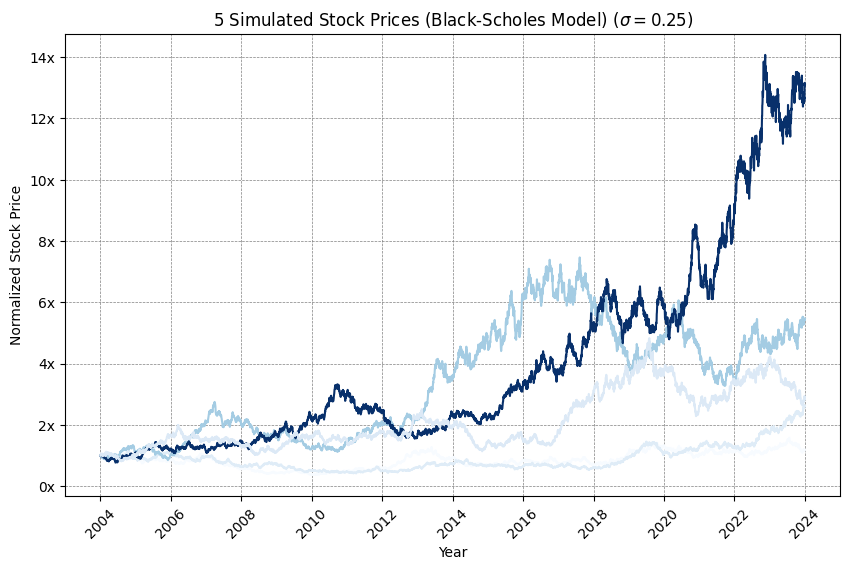

In [18]:
from matplotlib.ticker import FuncFormatter
from numpy.random import default_rng
import matplotlib.cm as cm

def black_scholes_sim(S0, r, sigma, T, N, M):
    dt = T / N
    paths = np.zeros((M, N + 1))
    paths[:, 0] = S0
    
    for i in range(1, N + 1):
        rand_nums = default_rng().standard_normal(M)
        paths[:, i] = paths[:, i-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * rand_nums)
    
    return paths

# Parameters
S0 = 100.0             # initial stock price
r = 0.08               # risk-free rate
sigma_p = 0.25         # volatility for positive correlation
sigma_n = 0.25         # volatility for negative correlation
T = 1.0 * 20           # time in years
N = 252 * 20           # number of time steps
M = 5                  # number of simulations

# Simulate stock prices using Black-Scholes model
S_p = black_scholes_sim(S0, r, sigma_p, T, N, M)
S_n = black_scholes_sim(S0, r, sigma_n, T, N, M)

# Normalize S_p and S_n
S_p_norm = S_p / S_p[:, 0].reshape(-1, 1)
S_n_norm = S_n / S_n[:, 0].reshape(-1, 1)

# Calculate the final values to determine color and alpha mapping
final_values = S_p_norm[:, -1]
norm = plt.Normalize(final_values.min(), final_values.max())
colors = cm.Blues(norm(final_values))  # Use a colormap with cool colors

# Normalize the final values for alpha transparency (0.1 to 1.0)
alpha_values = norm(final_values)
alpha_values = 0.1 + (alpha_values * 0.9)

# Plot the simulated stock prices with dark background and neon colors
fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')

# Set the figure and axes background color
ax.set_facecolor('white')

# Plot each stock path with varying transparency based on final value
for i in range(M):
    ax.plot(S_p_norm[i], color=colors[i], alpha=1)

# Customize plot elements
ax.set_title(f'{M} Simulated Stock Prices (Black-Scholes Model) ($σ={sigma_p}$)', color='black')
ax.set_xlabel('Year', color='black')
ax.set_ylabel('Normalized Stock Price', color='black')

# Set the y-axis formatter
formatter = FuncFormatter(lambda y, _: '{:,.0f}x'.format(y))
ax.yaxis.set_major_formatter(formatter)
ax.yaxis.set_tick_params(labelcolor='black')

# Generate the years for the x-axis
years = np.linspace(2004, 2004 + T, N + 1)
ax.set_xticks(np.arange(0, N + 1, N // 10))  # Set x-ticks every 10 years
ax.set_xticklabels(years[::N//10].astype(int), color='black')  # Set x-tick labels as years
plt.xticks(rotation=45)
ax.xaxis.set_tick_params(labelcolor='black')

# Customize gridlines
ax.grid(color='gray', linestyle='--', linewidth=0.5)

plt.show()


In [19]:
import pandas as pd

def black_scholes_sim(S0, r, sigma, T, N, M):
    dt = T / N
    paths = np.zeros((M, N + 1))
    paths[:, 0] = S0
    
    for i in range(1, N + 1):
        rand_nums = default_rng().standard_normal(M)
        paths[:, i] = paths[:, i-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * rand_nums)
    
    return paths

# Parameters
S0 = 100.0             # initial stock price
r = 0.08               # risk-free rate
sigma_p = 0.25         # volatility for positive correlation
sigma_n = 0.25         # volatility for negative correlation
T = 1.0 * 20           # time in years
N = 252 * 20           # number of time steps
M = 1                  # number of simulations

# Simulate stock prices using Black-Scholes model
S_p = black_scholes_sim(S0, r, sigma_p, T, N, M)
S_n = black_scholes_sim(S0, r, sigma_n, T, N, M)

# Create a DataFrame from the numpy array
df = pd.DataFrame(S_p)
S_p[0]

array([100.        ,  98.99544003,  99.8076089 , ..., 552.83994554,
       540.91027233, 532.61135639])

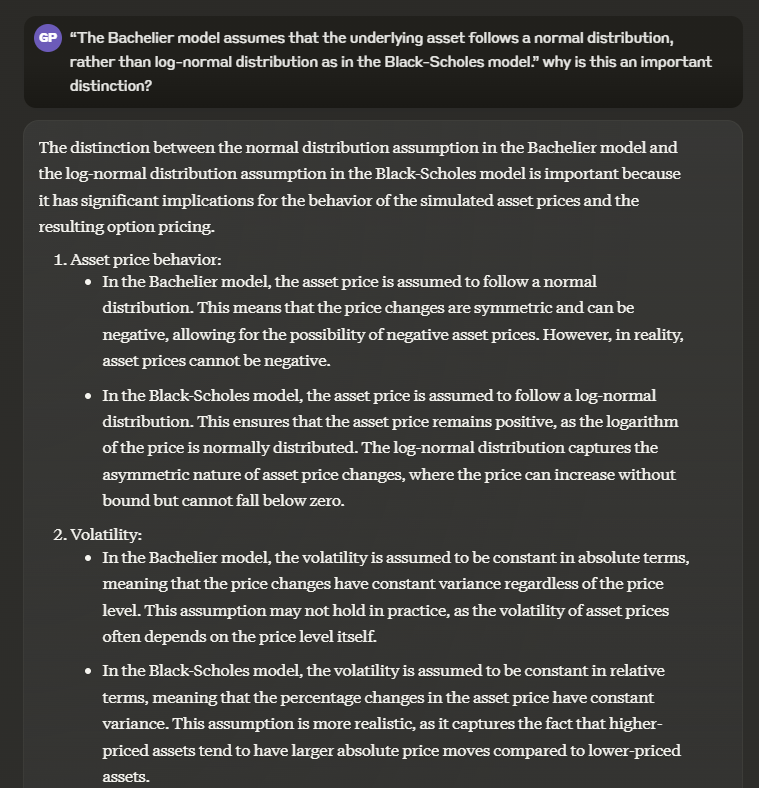 

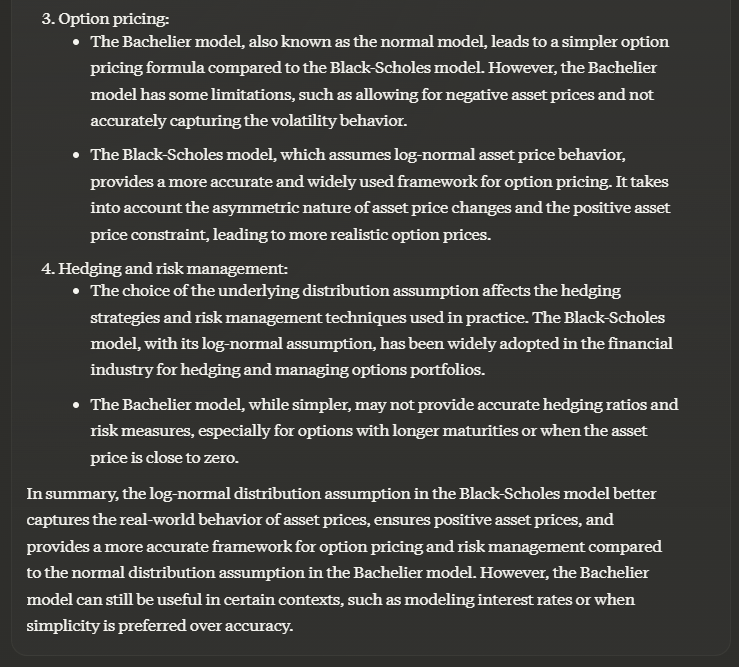

In [44]:
from hurst import compute_Hc

# Heston model simulation function
def heston_model_sim(S0, v0, rho, kappa, theta, sigma, T, N, M):
    dt = T / N
    mu = np.array([0, 0])
    cov = np.array([[1, rho], [rho, 1]])
    S = np.full(shape=(N + 1, M), fill_value=S0)
    v = np.full(shape=(N + 1, M), fill_value=v0)
    Z = np.random.multivariate_normal(mu, cov, (N, M))

    for i in range(1, N + 1):
        S[i] = S[i - 1] * np.exp((r - 0.5 * v[i - 1]) * dt + np.sqrt(v[i - 1] * dt) * Z[i - 1, :, 0])
        v[i] = np.maximum(v[i - 1] + kappa * (theta - v[i - 1]) * dt + sigma * np.sqrt(v[i - 1] * dt) * Z[i - 1, :, 1], 0)

    return S

# Black-Scholes model simulation function
def black_scholes_sim(S0, r, sigma, T, N, M):
    dt = T / N
    paths = np.zeros((M, N + 1))
    paths[:, 0] = S0
    
    for i in range(1, N + 1):
        rand_nums = np.random.default_rng().standard_normal(M)
        paths[:, i] = paths[:, i-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * rand_nums)
    
    return paths

# Parameters
S0 = 100.0
T = 1.0
r = 0.08
N = 252
M = 10000
kappa = 3
theta = 0.20**2
v0 = 0.25**2
rho_p = 0.98
rho_n = -0.98
sigma = 0.6

# Simulate paths
bs_sim = black_scholes_sim(S0, r, 0.25, T, N, M)
heston_sim_p = heston_model_sim(S0, v0, rho_p, kappa, theta, sigma, T, N, M)
# heston_sim_n = heston_model_sim(S0, v0, rho_n, kappa, theta, sigma, T, N, M)

# Compute Hurst exponents
hurst_black_scholes = [compute_Hc(path)[0] for path in bs_sim]
hurst_heston_p = [compute_Hc(heston_sim_p[:, i])[0] for i in range(M)]
# hurst_heston_n = [compute_Hc(heston_sim_n[:, i])[0] for i in range(M)]

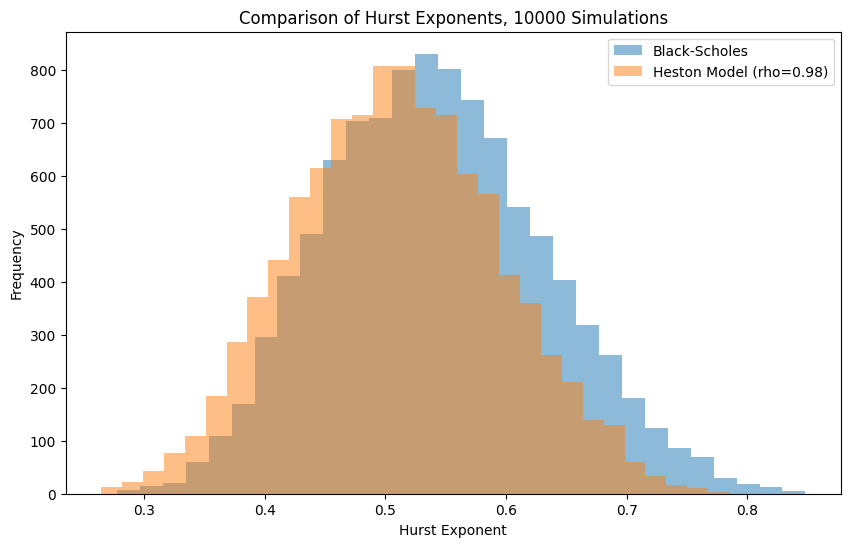

In [45]:
# Plot the histogram of Hurst exponents
plt.figure(figsize=(10, 6))
plt.hist(hurst_black_scholes, bins=30, alpha=0.5, label='Black-Scholes')
plt.hist(hurst_heston_p, bins=30, alpha=0.5, label='Heston Model (rho=0.98)')
# plt.hist(hurst_heston_n, bins=30, alpha=0.5, label='Heston Model (rho=-0.98)')
plt.xlabel('Hurst Exponent')
plt.ylabel('Frequency')
plt.title(f'Comparison of Hurst Exponents, {M} Simulations')
plt.legend()
plt.show()

In [46]:
pdbs, pdhp = pd.DataFrame(hurst_black_scholes), pd.DataFrame(hurst_heston_p)
pdbs.describe()

,0
count,10000.000000
mean,0.541714
std,0.090984
min,0.277372
25%,0.475712
50%,0.537286
75%,0.601946
max,0.848115


In [47]:
pdhp.describe()

,0
count,10000.000000
mean,0.509526
std,0.085204
min,0.264158
25%,0.448717
50%,0.508329
75%,0.568050
max,0.784970


In [48]:
from hurst import compute_Hc

# Heston model simulation function
def heston_model_sim(S0, v0, rho, kappa, theta, sigma, T, N, M):
    dt = T / N
    mu = np.array([0, 0])
    cov = np.array([[1, rho], [rho, 1]])
    S = np.full(shape=(N + 1, M), fill_value=S0)
    v = np.full(shape=(N + 1, M), fill_value=v0)
    Z = np.random.multivariate_normal(mu, cov, (N, M))

    for i in range(1, N + 1):
        S[i] = S[i - 1] * np.exp((r - 0.5 * v[i - 1]) * dt + np.sqrt(v[i - 1] * dt) * Z[i - 1, :, 0])
        v[i] = np.maximum(v[i - 1] + kappa * (theta - v[i - 1]) * dt + sigma * np.sqrt(v[i - 1] * dt) * Z[i - 1, :, 1], 0)

    return S

# Black-Scholes model simulation function
def black_scholes_sim(S0, r, sigma, T, N, M):
    dt = T / N
    paths = np.zeros((M, N + 1))
    paths[:, 0] = S0
    
    for i in range(1, N + 1):
        rand_nums = np.random.default_rng().standard_normal(M)
        paths[:, i] = paths[:, i-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * rand_nums)
    
    return paths

# Parameters
S0 = 100.0
T = 1.0
r = 0.00
N = 252
M = 10000
kappa = 3
theta = 0.20**2
v0 = 0.25**2
rho_p = 0.98
rho_n = -0.98
sigma = 0.6

# Simulate paths
bs_sim = black_scholes_sim(S0, r, 0.25, T, N, M)
heston_sim_p = heston_model_sim(S0, v0, rho_p, kappa, theta, sigma, T, N, M)
# heston_sim_n = heston_model_sim(S0, v0, rho_n, kappa, theta, sigma, T, N, M)

# Compute Hurst exponents
hurst_black_scholes = [compute_Hc(path)[0] for path in bs_sim]
hurst_heston_p = [compute_Hc(heston_sim_p[:, i])[0] for i in range(M)]

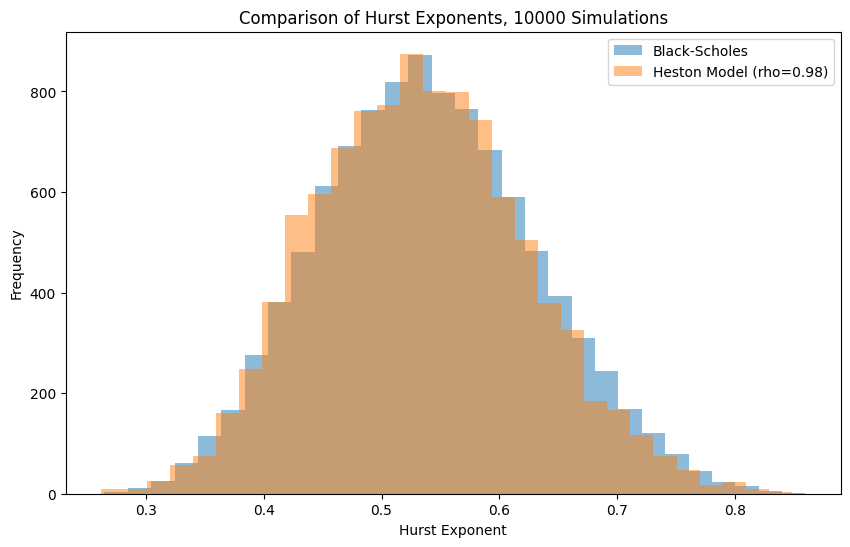

In [49]:
# Plot the histogram of Hurst exponents
plt.figure(figsize=(10, 6))
plt.hist(hurst_black_scholes, bins=30, alpha=0.5, label='Black-Scholes')
plt.hist(hurst_heston_p, bins=30, alpha=0.5, label='Heston Model (rho=0.98)')
# plt.hist(hurst_heston_n, bins=30, alpha=0.5, label='Heston Model (rho=-0.98)')
plt.xlabel('Hurst Exponent')
plt.ylabel('Frequency')
plt.title(f'Comparison of Hurst Exponents, {M} Simulations')
plt.legend()
plt.show()

In [50]:
pdbs, pdhp = pd.DataFrame(hurst_black_scholes), pd.DataFrame(hurst_heston_p)
pdbs.describe()

,0
count,10000.000000
mean,0.539500
std,0.091998
min,0.265017
25%,0.474282
50%,0.536680
75%,0.601070
max,0.859436


In [51]:
pdhp.describe()

,0
count,10000.000000
mean,0.533107
std,0.089727
min,0.262031
25%,0.468774
50%,0.530680
75%,0.592487
max,0.847745


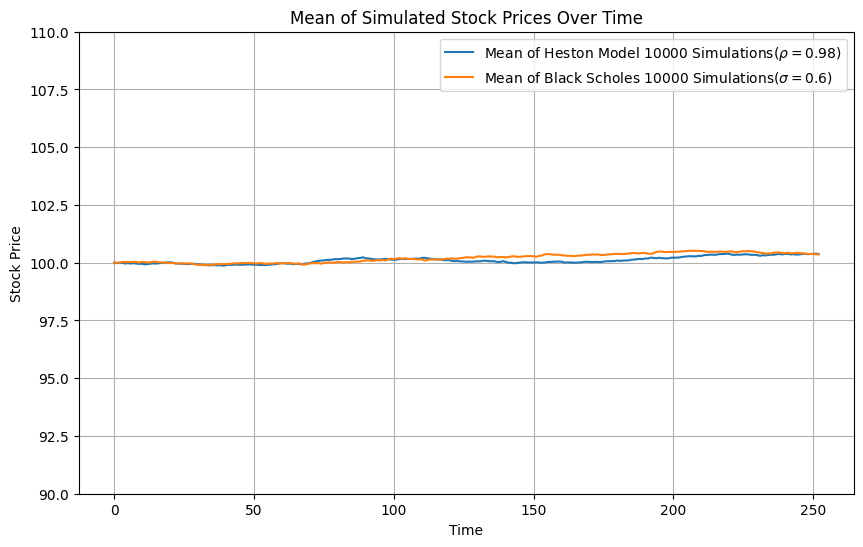

In [52]:
# Calculate the mean of all simulated stock prices at each time step
mean_Sim_hm = np.mean(heston_sim_p, axis=1)
mean_Sim_bm = np.mean(bs_sim, axis=0)

# Plot the mean of the simulated stock prices
plt.figure(figsize=(10, 6))
plt.plot(mean_Sim_hm, label=f'Mean of Heston Model {M} Simulations($ρ={rho_p}$)')
plt.plot(mean_Sim_bm, label=f'Mean of Black Scholes {M} Simulations($σ={sigma}$)')
plt.title('Mean of Simulated Stock Prices Over Time')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.ylim(90, 110)
plt.legend()
plt.grid(True)
plt.show()